This example will show how to generate the trajectory analysis from [1] using the MindScoPy package. The notebook will walk you through analyzing a single individual from the BCI Competition IV-2a dataset. See the `bci_comp_iv2a_preprocessing.py` file for data preprocessing and preparation steps.

[1] Ivanov, N., Wong, M., and Chau, T. (2025). A multi-class intra-trial
            trajectory analysis technique to visualize and quantify variability
            of mental imagery EEG signals. International Journal of Neural Systems. 
            https://10.1142/S0129065725500753.

In [36]:
import mindscopy as ms
from mindscopy.preprocessing.artifact_removal import peak_rejection, riemannian_potato_rejection
from mindscopy.preprocessing.misc import epoch
from mindscopy.preprocessing.rebias import apply_rebias_to_groups
from mindscopy.preprocessing.feature_extraction import ScaledTangentSpace
import numpy as np
import pyriemann
import pickle

In [37]:
# load the preprocessed (bandpass filtered and epoched) BCI Competition IV 2a data
with open('data/BCI_Comp_IV_2a/preprocessed_data.pkl', 'rb') as f:
    d = pickle.load(f)


In [38]:
# select data from one person
p = 9

# Extract all data from both sessions
X = np.concatenate([d[p][1]['trials'], d[p][2]['trials']])
y = np.concatenate([d[p][1]['labels'], d[p][2]['labels']])
blocks = np.concatenate([
    d[p][1]['run_labels'], 
    d[p][2]['run_labels']+(1+max(d[p][1]['run_labels'])) # shift the second session's block labels
])

Perform the preprocessing steps of artifact rejecting and sub-epoching.

In [39]:
print(X.shape)

(501, 22, 1501)


In [40]:
# apply peak rejection
X, rejected_trials = peak_rejection(X, threshold=100, verbose=True)
y = np.delete(y, rejected_trials)
blocks = np.delete(blocks, rejected_trials)

0 trials rejected.


In [41]:
# apply riemannian potato rejection to each block of trials
clean_X = []
clean_y = []
clean_blocks = []
for block in np.unique(blocks):
    block_idx = blocks == block
    X_block = X[block_idx]
    y_block = y[block_idx]
    blocks_block = blocks[block_idx]

    X_block, rejected_trials = riemannian_potato_rejection(X_block, threshold=2.5, verbose=True)
    y_block = np.delete(y_block, rejected_trials)
    blocks_block = np.delete(blocks_block, rejected_trials)

    clean_X.append(X_block)
    clean_y.append(y_block)
    clean_blocks.append(blocks_block)

X = np.concatenate(clean_X)
y = np.concatenate(clean_y)
blocks = np.concatenate(clean_blocks)

Potato filtering: 3 trials rejected.
Potato filtering: 0 trials rejected.
Potato filtering: 0 trials rejected.
Potato filtering: 3 trials rejected.
Potato filtering: 1 trials rejected.
Potato filtering: 2 trials rejected.
Potato filtering: 1 trials rejected.
Potato filtering: 2 trials rejected.
Potato filtering: 3 trials rejected.
Potato filtering: 8 trials rejected.
Potato filtering: 1 trials rejected.
Potato filtering: 5 trials rejected.


Now compute the mean covariance matrix for each block. These will be used for rebiasing the sub-epoch covariance matrices.

In [42]:
n_trials, n_channels, n_samples = X.shape
n_blks = len(np.unique(blocks))

# block means
block_means = np.zeros((n_blks, n_channels, n_channels))
for i, block in enumerate(np.sort(np.unique(blocks))):
    block_covs = pyriemann.utils.covariance.covariances(X[blocks == block])
    block_means[i] = pyriemann.utils.mean.mean_covariance(block_covs)

In [43]:
# Generate sub-epochs for each trial
Fs = 250
length = 2
stride = 0.5
n_samples_epoch = int(Fs * length)
Xtraj = epoch(X, n_samples_epoch, int(Fs * stride))
n_epochs = Xtraj.shape[1]

In [44]:
# apply the rebiasing to the sub-epochs
blocks_epochs = np.repeat(blocks, Xtraj.shape[1])

Xtraj = np.reshape(Xtraj, (-1, n_channels, n_samples_epoch))
Xtraj_covs = pyriemann.utils.covariance.covariances(Xtraj)
Xtraj_covs = apply_rebias_to_groups(Xtraj_covs, blocks_epochs, block_means)

In [45]:
# apply feature extraction
feature_extractor = ScaledTangentSpace().fit(Xtraj_covs)
Xtraj_features = feature_extractor.transform(Xtraj_covs)

In [46]:
# put the data back into trial, epoch, format
Xtraj_features = np.reshape(Xtraj_features, (n_trials, n_epochs, -1))
print(Xtraj_features.shape)

(472, 9, 253)


In [47]:
# Perform clustering and generate the trajectory sub-space
np.random.seed(42)
subspace = ms.SubspaceTrajectoryModel(krange=range(2,12)).fit(Xtraj_features, y=y, verbose=True)

Selecting the number of clusters using prediction strength.
Prediction strength criterion for k selection:
[0.94458034 0.80224445 0.46642523 0.4021879  0.42755118 0.36285971
 0.29048056 0.26130452 0.22773629 0.19443498]
Number of clusters selected: 7
Singular values: [9.54449485e+00 4.70769135e+00 4.06593875e+00 3.81845834e+00
 3.16361954e+00 1.36958599e+00 8.80282409e-16]
w shape: (253, 7), U shape: (253, 7)


In [48]:
chs = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
ch_map = {
    ch : i for _, ch in enumerate(chs)
}

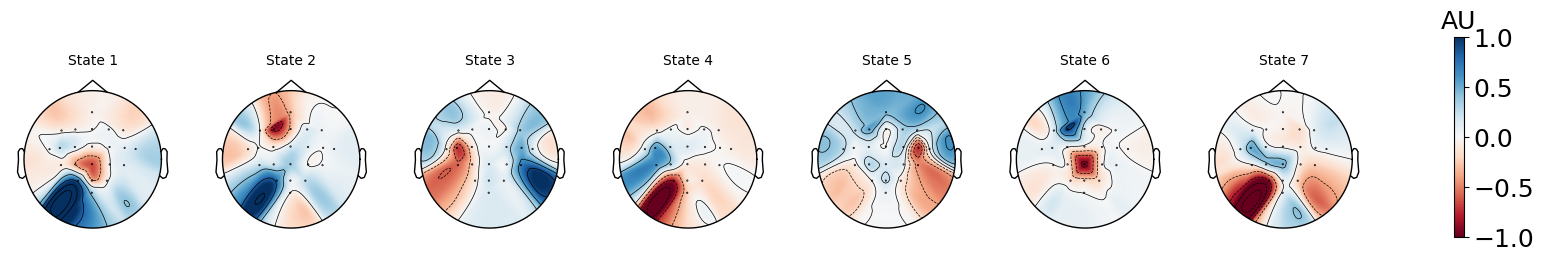

In [49]:
# visulize the pattern state activation patterns
subspace.plot_activation_patterns(np.reshape(Xtraj_features, (-1, Xtraj_features.shape[-1])), Xtraj_covs, list(ch_map.keys()))

In [50]:
# select a block and task to analyze
block = 4
task = 1

X_blk = Xtraj_features[blocks == block]
y_blk = y[blocks == block]

X_task = X_blk[y_blk == task]

In [51]:
Traj_all_tasks = ms.Trajectory(subspace)
Traj_all_tasks.fit(X_blk)

Traj_task = ms.Trajectory(subspace)
Traj_task.fit(X_task)

In [52]:
# compute the InterTaskDiff
InterTaskDiff = Traj_task.inter_task_diff(Traj_all_tasks)
print(np.log(InterTaskDiff))

[-4.10790572 -3.37980985 -2.35892257 -1.57842272 -0.75551299  0.03523664
 -0.30501443 -1.60865345 -3.58396065]


In [53]:
# Computer InterTrialVar
InterTrialVar = Traj_task.inter_trial_var(Traj_all_tasks)
print(InterTrialVar)

[0.84817337 0.86305544 0.90492685 1.1479705  1.00257945 0.55290949
 0.51893775 0.75227132 0.85925386]


In [54]:
# Compute IntraTrialVar
IntraTrialVar = Traj_task.intra_trial_var()
print(IntraTrialVar)

0.4177598422509273


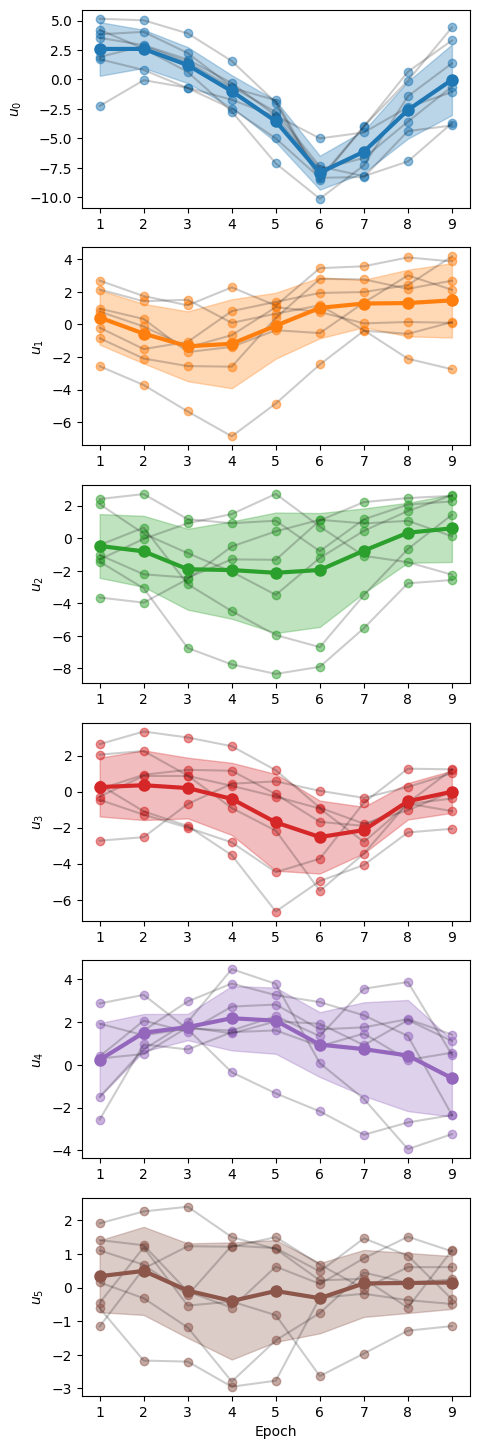

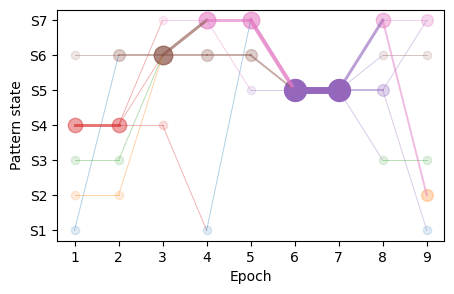

In [55]:
# visualize the trajectory
Traj_task.plot_trajectory(box_plot=False, plot_all_pts=True)
Traj_task.plot_trellis()